## Competition: Child Mind Institute - Problematic Internet Usage

- ## Prédiction de l'utilisation problématique d'Internet chez les enfants
- ## Utilisation de modèles deep learning pour analyser l'activité physique




"""
pour installer les dépendances (première exéc)
#%pip install tensorflow-addons
#import tensorflow_addons as tfa
Cependant, cela ná pas marché sur Kaggle car Kaggle Tensorflow 2.16.1 est incompatible
"""

In [23]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from tensorflow.keras.metrics import Metric

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import time
import os
import numpy as np

import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import time
import os
import numpy as np
import pandas as pd


In [24]:
# Vérification environnement Kaggle
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# Configuration du chemin des données
if IN_KAGGLE:
    DATA_PATH = '/kaggle/input/child-mind-institute-problematic-internet-use'
else:
    DATA_PATH = '.'
print(f'IN_KAGGLE: {IN_KAGGLE}')

IN_KAGGLE: False


In [25]:
# Configuration de TensorBoard pour Kaggle
def setup_tensorboard():
    """
    Configure TensorBoard en fonction de l'environnement
    """
    if IN_KAGGLE:
        log_dir = '/kaggle/working/logs'
    else:
        log_dir = 'logs'
    
    os.makedirs(log_dir, exist_ok=True)
    return log_dir

# Configuration des seeds pour reproductibilité
def set_seeds(seed=25):
    """
    Configure les seeds pour la reproductibilité
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)

In [26]:
def load_accelerometer_data(data_path, is_train=True):
    """
    Charge les données d'accéléromètre en ignorant les fichiers système
    """

    
    def process_file(filename, dirname):
        """Traite un fichier parquet individuel"""
        try:
            df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
            
            # Calcul des statistiques par colonnes
            stats = []
            for col in ['X', 'Y', 'Z', 'enmo', 'anglez']:
                desc = df[col].describe()
                stats.extend([desc['mean'], desc['std'], desc['max']])
            
            stats.extend([
                df['non-wear_flag'].mean(),
                df['light'].mean(),
                df['weekday'].mean()
            ])
            
            return stats, filename.split('=')[1]
        except Exception as e:
            print(f"Erreur lors du traitement du fichier {filename}: {str(e)}")
            return None
    
    # chemin du dossier
    dirname = os.path.join(data_path, 'series_train.parquet' if is_train else 'series_test.parquet')
    
    # Liste des IDs (sous-dossiers) en filtrant autres fichiers cachés (pa ex .DS_Store sur Mac OS)
    ids = [d for d in os.listdir(dirname) 
           if not d.startswith('.') and  # Ignore les fichiers cachés
           os.path.isdir(os.path.join(dirname, d)) and  # Vérifie que c'est un dossier
           d.startswith('id=')]  # Vérifie que c'est un dossier d'ID
    
    print(f"Traitement de {len(ids)} fichiers valides...")
    # Traitements parallèle
    valid_results = []
    with ThreadPoolExecutor() as executor:
        futures = list(tqdm(
            executor.map(lambda fname: process_file(fname, dirname), ids),
            total=len(ids)
        ))
        valid_results = [r for r in futures if r is not None]
    
    if not valid_results:
        raise ValueError("Aucune donnée n'a pu être extraite")
    
    stats, indexes = zip(*valid_results)
    
    # noms de colonnes (accelerometre)
    col_names = []
    for col in ['X', 'Y', 'Z', 'enmo', 'anglez']:
        col_names.extend([f"accel_{col}_mean", f"accel_{col}_std", f"accel_{col}_max"])
    col_names.extend(['accel_nonwear_mean', 'accel_light_mean', 'accel_weekday_mean'])
    
    # DataFrame accel chargé
    accel_features = pd.DataFrame(stats, columns=col_names)
    accel_features['id'] = indexes
    
    return accel_features

def load_data():
    """
    Charge données .csv et .parquet
    """
    print(f"Chargement des données depuis {DATA_PATH}")
    
    # Chargement données tabulaires
    train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
    test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
    
    print(f"Dimensions des données tabulaires:")
    print(f"Train: {train_df.shape}")
    print(f"Test: {test_df.shape}")
    
    # Chargement données d'accéléromètre
    print("Chargement des données d'accéléromètre...")
    try:
        accel_train = load_accelerometer_data(DATA_PATH, is_train=True)
        accel_test = load_accelerometer_data(DATA_PATH, is_train=False)
        
        print(f"Dimensions des données d'accéléromètre:")
        print(f"Train: {accel_train.shape}")
        print(f"Test: {accel_test.shape}")
        
    except Exception as e:
        print(f"Erreur lors du chargement des données d'accéléromètre: {str(e)}")
        raise
    
    return train_df, test_df, accel_train, accel_test

In [27]:
def create_missing_indicators(df):
    """
    Crée des indicateurs de val manquantes pour chaque colonne
    """
    missing_indicators = pd.DataFrame()
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().any():
            missing_indicators[f'{col}_missing'] = df[col].isnull().astype(int)
    return missing_indicators


In [28]:
# Non-utilisé pour le moment
def impute_missing_accel_features(features_df, all_ids, accel_features):
    """
    Impute les valeurs manquantes pour les IDs sans données d'accéléromètre
    """
    # Créer un DataFrame avec tous les IDs
    complete_features = pd.DataFrame(index=all_ids)
    
    # Ajouter un flag pour indiquer la présence de données d'accéléromètre
    complete_features['has_accel_data'] = complete_features.index.isin(accel_features.index).astype(int)
    
    # Fusionner avec les features existantes
    complete_features = complete_features.join(accel_features)
    
    # Imputation des valeurs manquantes pour chaque type de feature
    for col in complete_features.columns:
        if col == 'has_accel_data':
            continue
            
        if 'non-wear_flag' in col:
            complete_features[col].fillna(1, inplace=True)
        elif any(x in col for x in ['X_', 'Y_', 'Z_', 'anglez_', 'enmo_', 'light_']):
            complete_features[col].fillna(0, inplace=True)
        else:  # weekday et time_of_day
            complete_features[col].fillna(complete_features[col].mean(), inplace=True)
    
    return complete_features


In [29]:
def process_categorical_seasons(df):
    """
    Convertit les colonnes de saisons en variables dummy
    """
    season_columns = [col for col in df.columns if col.endswith('Season')]
    for col in season_columns:
        if col in df.columns:
            season_dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
            df = pd.concat([df, season_dummies], axis=1)
            df = df.drop(col, axis=1)
    return df

def preprocess_tabular_data(train_df, test_df, target_col='sii'):
    """
    Prétraite les données tabulaires
    """
    # 1. Suppression des lignes sans target dans train_df
    train_df = train_df.dropna(subset=[target_col])
    
    # 2. Identification des colonnes communes car on veut matcher les variables dans les 2 datasets
    common_columns = list(set(test_df.columns) & set(train_df.columns))
    train_df = train_df[common_columns + [target_col]]
    
    # 3. Séparation des colonnes numériques et catégorielles car traitement différent pour chacun
    numeric_columns = train_df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
    numeric_columns = [col for col in numeric_columns if col != target_col]
    
    # 4. Indicateurs de valeurs manquantes
    train_missing = create_missing_indicators(train_df)
    test_missing = create_missing_indicators(test_df)
    
    # 5. Traitement variables catégorielles (saisons)
    train_df = process_categorical_seasons(train_df)
    test_df = process_categorical_seasons(test_df)
    
    # 6. Imputation KNN pour variables numériques
    imputer = KNNImputer(n_neighbors=5)
    train_numeric = train_df[numeric_columns].copy()
    test_numeric = test_df[numeric_columns].copy()
    
    train_numeric_imputed = pd.DataFrame(
        imputer.fit_transform(train_numeric),
        columns=train_numeric.columns,
        index=train_numeric.index
    )
    test_numeric_imputed = pd.DataFrame(
        imputer.transform(test_numeric),
        columns=test_numeric.columns,
        index=test_numeric.index
    )
    
    # 7. Standardisation des variables numériques, on pourrait également utiliser RobustScaler puis MinMaxScaler
    scaler = StandardScaler()
    train_numeric_scaled = pd.DataFrame(
        scaler.fit_transform(train_numeric_imputed),
        columns=train_numeric_imputed.columns,
        index=train_numeric_imputed.index
    )
    test_numeric_scaled = pd.DataFrame(
        scaler.transform(test_numeric_imputed),
        columns=test_numeric_imputed.columns,
        index=test_numeric_imputed.index
    )
    
    # 8. dataset au complet, on concatène les variables numériques, catégorielles et les indicateurs de valeurs manquantes
    train_processed = pd.concat([
        train_numeric_scaled,
        train_df.select_dtypes(include=['object']),
        train_missing
    ], axis=1)
    
    test_processed = pd.concat([
        test_numeric_scaled,
        test_df.select_dtypes(include=['object']),
        test_missing
    ], axis=1)
    
    # 9. Récupération des targets
    y = train_df[target_col].values
    
    return train_processed, test_processed, y, scaler


In [30]:
def process_categorical_seasons(df):
    """
    Convertit les colonnes de saisons en variables dummy
    """
    season_columns = [col for col in df.columns if col.endswith('Season')]
    for col in season_columns:
        if col in df.columns:
            season_dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
            df = pd.concat([df, season_dummies], axis=1)
            df = df.drop(col, axis=1)
    return df


In [31]:
def prepare_data_for_model(train_df, test_df, accel_train, accel_test, test_size=0.2, random_state=42):
    """
    Prépare les données pour l'entraînement du modèle avec les features d'accéléromètre pré-calculées
    """
    # 1. Suppression des lignes sans target
    train_df = train_df.dropna(subset=['sii'])
    
    # 2. Fusion des données tabulaires & d'accéléromètre
    train_df = train_df.merge(accel_train, on='id', how='left')
    test_df = test_df.merge(accel_test, on='id', how='left')
    
    # 3. Identification colonnes communes
    common_columns = list(set(test_df.columns) & set(train_df.columns))
    y = train_df['sii'].values
    train_df = train_df[common_columns]
    
    # 4. Indicateurs valeurs manquantes
    train_missing = create_missing_indicators(train_df)
    test_missing = create_missing_indicators(test_df)
    
    # 5. Traitement variables catégorielles (saisons)
    train_df = process_categorical_seasons(train_df)
    test_df = process_categorical_seasons(test_df)
    
    # 6. Identification des colonnes numériques
    numeric_columns = train_df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
    
    # 7. Imputation KNN pour variables numériques
    imputer = KNNImputer(n_neighbors=5)
    
    train_numeric = pd.DataFrame(
        imputer.fit_transform(train_df[numeric_columns]),
        columns=numeric_columns,
        index=train_df.index
    )
    
    test_numeric = pd.DataFrame(
        imputer.transform(test_df[numeric_columns]),
        columns=numeric_columns,
        index=test_df.index
    )
    
    # 8. Standardisation
    scaler = StandardScaler()
    train_numeric_scaled = pd.DataFrame(
        scaler.fit_transform(train_numeric),
        columns=train_numeric.columns,
        index=train_numeric.index
    )
    
    test_numeric_scaled = pd.DataFrame(
        scaler.transform(test_numeric),
        columns=test_numeric.columns,
        index=test_numeric.index
    )
    
    # 9. Reconstruction des datasets finaux
    train_processed = pd.concat([
        train_numeric_scaled,
        train_df.select_dtypes(include=['object']),
        train_missing
    ], axis=1)
    
    test_processed = pd.concat([
        test_numeric_scaled,
        test_df.select_dtypes(include=['object']),
        test_missing
    ], axis=1)
    
    # 10. Split avec stratification sur la target
    X_train, X_val, y_train, y_val = train_test_split(
        train_processed, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    return X_train, X_val, test_processed, y_train, y_val, scaler

In [32]:
# Configuration initiale (inchangée)
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
DATA_PATH = '/kaggle/input/child-mind-institute-problematic-internet-use' if IN_KAGGLE else '.'

# Chargement des données avec la nouvelle approche
train_df, test_df, accel_train, accel_test = load_data()

# Le reste de votre pipeline reste inchangé
X_train, X_val, X_test, y_train, y_val, scaler = prepare_data_for_model(
    train_df, test_df, accel_train, accel_test
)

Chargement des données depuis .
Dimensions des données tabulaires:
Train: (3960, 82)
Test: (20, 59)
Chargement des données d'accéléromètre...
Traitement de 996 fichiers valides...


100%|██████████| 996/996 [00:08<00:00, 123.89it/s]


Traitement de 2 fichiers valides...


100%|██████████| 2/2 [00:00<00:00, 40.47it/s]


Dimensions des données d'accéléromètre:
Train: (996, 19)
Test: (2, 19)


In [33]:
accel_train.id.unique().shape

(996,)

In [34]:
print("Nombre total d'IDs dans test_df:", test_df.id.nunique())
print("Nombre d'IDs dans accel_test:", accel_test.id.nunique())
print("IDs dans test_df:", test_df.id.unique())
print("IDs dans accel_test:", accel_test.id.unique())

Nombre total d'IDs dans test_df: 20
Nombre d'IDs dans accel_test: 2
IDs dans test_df: ['00008ff9' '000fd460' '00105258' '00115b9f' '0016bb22' '001f3379'
 '0038ba98' '0068a485' '0069fbed' '0083e397' '0087dd65' '00abe655'
 '00ae59c9' '00af6387' '00bd4359' '00c0cd71' '00d56d4b' '00d9913d'
 '00e6167c' '00ebc35d']
IDs dans accel_test: ['001f3379' '00115b9f']


In [35]:
X_test, y_train, y_val

(    BIA-BIA_BMI  BIA-BIA_BMR  BIA-BIA_FFMI  accel_nonwear_mean  \
 0     -0.499519    -0.200013     -0.364405           -0.907008   
 1     -1.154787    -0.197420     -0.532643            0.031675   
 2     -0.437577    -0.085363     -0.384824            0.271822   
 3     -0.173256    -0.075927     -0.320950           -1.211761   
 4      1.618796     0.088471      0.008700           -0.339327   
 5      2.568583     0.048539      0.122186            1.662499   
 6      0.142285    -0.073164     -0.214816           -0.040816   
 7     -0.503231    -0.045606     -0.399754            0.569417   
 8      0.442292     0.158470      0.003692            0.688956   
 9      2.105909     0.149013      0.226052           -0.468585   
 10     0.463918    -0.021340     -0.216020            0.686181   
 11     0.715530     0.010344     -0.045829            0.103802   
 12     0.469331    -0.008542     -0.052105            0.413680   
 13    -0.446020    -0.084101     -0.401189           -0.18262

In [36]:
def prepare_data_for_training(X_train, X_val, X_test, y_train, y_val):
    """
    Prépare les données pour l'entraînement 
    """
    # Suppression des colonnes non numériques
    if isinstance(X_train, pd.DataFrame):
        # Identification des colonnes numériques
        numeric_cols = X_train.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
        X_train = X_train[numeric_cols]
        X_val = X_val[numeric_cols]
        if X_test is not None:
            X_test = X_test[numeric_cols]
    
    # Conversion en array numpy si ce n'est pas déjà fait
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.astype('float32').to_numpy()
    if isinstance(X_val, pd.DataFrame):
        X_val = X_val.astype('float32').to_numpy()
    if X_test is not None and isinstance(X_test, pd.DataFrame):
        X_test = X_test.astype('float32').to_numpy()
        
    # Conversion des labels en int32
    y_train = y_train.astype('int32')
    y_val = y_val.astype('int32')
    
    return X_train, X_val, X_test, y_train, y_val


In [37]:
def create_linear_model(input_shape):
    """
    modèle linéaire
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(4, activation='softmax', name='output')
    ])
    return model

def create_mlp_model(input_shape, dropout_rate=0.3):
    """
    Crée un MLP
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(4, activation='softmax', name='output')
    ])
    return model

def create_cnn_model(input_shape, dropout_rate=0.3):
    """
    Crée un CNN 1D notamment pour données tabulaires
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Reshape((-1, 1)),
        layers.Conv1D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(dropout_rate),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(dropout_rate),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(4, activation='softmax', name='output')
    ])
    return model


In [38]:
# Fonction pour calculer le kappa
def calculate_quadratic_weighted_kappa(y_true, y_pred):
    """
    Calcule le quadratic weighted kappa
    """
    # Création de la matrice O (observed)
    O = confusion_matrix(y_true, y_pred)
    O = O.astype(float)
    
    # Normalisation de O
    O_norm = O / float(np.sum(O))
    
    # Création de la matrice E (expected)
    row_sums = np.sum(O, axis=1)
    col_sums = np.sum(O, axis=0)
    E = np.outer(row_sums, col_sums) / float(np.sum(O))
    
    # Création de la matrice W (weights)
    n_classes = O.shape[0]
    W = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            W[i, j] = ((i - j) ** 2) / ((n_classes - 1) ** 2)
    
    # Calcul du kappa
    numerator = np.sum(W * O_norm)
    denominator = np.sum(W * E / float(np.sum(E)))
    kappa = 1 - (numerator / denominator)
    
    return kappa

In [ ]:
class QuadraticKappa(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, name='quadratic_kappa', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.confusion_matrix = self.add_weight(
            'confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Conversion des prédictions en classes
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)
        
        # Création de la matrice de confusion pour ce batch
        current_confusion = tf.cast(
            tf.math.confusion_matrix(
                y_true, y_pred, 
                num_classes=self.num_classes
            ), 
            tf.float32
        )
        
        # Mise à jour de la matrice de confusion totale
        self.confusion_matrix.assign_add(current_confusion)

    def result(self):
        # Normalisation de la matrice de confusion
        sum_over_row = tf.reduce_sum(self.confusion_matrix, axis=0)
        sum_over_col = tf.reduce_sum(self.confusion_matrix, axis=1)
        expected = tf.matmul(
            tf.expand_dims(sum_over_row, 1),
            tf.expand_dims(sum_over_col, 0)
        )
        expected = expected / tf.reduce_sum(expected)
        
        # Création de la matrice de poids
        w_mat = tf.cast(tf.range(self.num_classes), tf.float32)
        w_mat = tf.reshape(w_mat, [-1, 1]) - tf.reshape(w_mat, [1, -1])
        w_mat = tf.pow(w_mat, 2.0)
        w_mat = w_mat / tf.pow(tf.cast(self.num_classes - 1, tf.float32), 2.0)
        
        # Normalisation de la matrice observée
        observed = self.confusion_matrix / tf.reduce_sum(self.confusion_matrix)
        
        # Calcul du kappa
        nom = tf.reduce_sum(w_mat * observed)
        denom = tf.reduce_sum(w_mat * expected)
        kappa = 1.0 - (nom / (denom + tf.keras.backend.epsilon()))
        
        return kappa

    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros(s.shape))

def train_model(model, X_train, y_train, X_val, y_val, model_name, batch_size=32, epochs=100):
    """
    Fonction d'entraînement modèle avec kappa metric personnalisée
    """
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    log_name = f"{model_name}_lr0.001_b{batch_size}_e{epochs}_{timestamp}"
    log_dir = os.path.join("logs", log_name)
    os.makedirs(log_dir, exist_ok=True)
    
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True
    )
    
    early_stopping = EarlyStopping(
        monitor='val_quadratic_kappa',
        mode='max',
        patience=10,
        restore_best_weights=True
    )
    
    kappa_metric = QuadraticKappa(num_classes=4)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', kappa_metric]
    )
    
    model.summary()
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[tensorboard_callback, early_stopping],
        verbose=1
    )
    
    return history

def evaluate_model(model, X_val, y_val):
    """
    Évaluation et métriques modèles
    """
    metrics = model.evaluate(X_val, y_val, verbose=0)
    metrics_dict = dict(zip(model.metrics_names, metrics))
    
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    return {
        'loss': metrics_dict['loss'],
        'accuracy': metrics_dict['accuracy'],
        'kappa': metrics_dict['quadratic_kappa'],
        'predictions': y_pred,
        'pred_classes': y_pred_classes
    }

In [40]:

# fonction d'entraînement de tous les modèles
def train_all_models(X_train, X_val, y_train, y_val, input_shape):
    """
    Entraine et retourne leurs performances avec kappa
    """
    X_train, X_val, _, y_train, y_val = prepare_data_for_training(
        X_train, X_val, None, y_train, y_val
    )
    
    input_shape = (X_train.shape[1],)
    
    models = {
        'linear': create_linear_model(input_shape),
        'mlp': create_mlp_model(input_shape),
        'cnn': create_cnn_model(input_shape)
    }
    
    histories = {}
    evaluations = {}
    
    for name, model in models.items():
        print(f"\nEntraînement du modèle {name}")
        history = train_model(model, X_train, y_train, X_val, y_val, name)
        histories[name] = history
        
        eval_results = evaluate_model(model, X_val, y_val)
        evaluations[name] = eval_results
        
        print(f"{name} - Validation Loss: {eval_results['loss']:.4f}, "
              f"Validation Accuracy: {eval_results['accuracy']:.4f}, "
              f"Quadratic Kappa: {eval_results['kappa']:.4f}")
    
    # Sélection du meilleur modèle basé sur le kappa
    best_model_name = max(evaluations.items(), key=lambda x: x[1]['kappa'])[0]
    print(f"\nMeilleur modèle (basé sur le kappa): {best_model_name}")
    
    return models, histories, best_model_name, evaluations


In [41]:
def generate_submission(best_model, X_test, test_df, output_file='submission.csv'):
    """
    Génère le fichier de soumission avec les prédictions
    """
    # Garde copie de l'ID avant préparation
    test_ids = test_df['id'].copy()
    
    # Sélection uniquement des colonnes numériques
    numeric_cols = X_test.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    X_test_numeric = X_test[numeric_cols].copy()
    
    # Conversion array numpy
    X_test_prepared = X_test_numeric.astype('float32').to_numpy()
    
    # Génération prédictions
    predictions = best_model.predict(X_test_prepared, verbose=0)
    predictions_classes = np.argmax(predictions, axis=1)
    
    # Création DataFrame de soumission
    submission = pd.DataFrame({
        'id': test_ids,
        'sii': predictions_classes
    })

    if IN_KAGGLE:
        output_file = f'/kaggle/working/{output_file}'
    
    submission.to_csv(output_file, index=False)
    print(f"Fichier de soumission généré : {output_file}")
    
    return submission

In [42]:
input_shape = (X_train.shape[1],)

# Entraînement de tous les modèles
models, histories, best_model_name, evaluations = train_all_models(
    X_train, X_val, y_train, y_val, input_shape
)



Entraînement du modèle linear
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              (None, 4)                 516       
                                                                 
Total params: 516 (2.02 KB)
Trainable params: 516 (2.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
69/69 [==============================] - 0s 3ms/step - loss: 1.4392 - accuracy: 0.3848 - quadratic_kappa: 0.0046 - val_loss: 1.2369 - val_accuracy: 0.4763 - val_quadratic_kappa: 0.0544
Epoch 2/100
69/69 [==============================] - 0s 794us/step - loss: 1.1450 - accuracy: 0.5091 - quadratic_kappa: 0.1465 - val_loss: 1.0941 - val_accuracy: 0.5201 - val_quadratic_kappa: 0.1571
Epoch 3/100
69/69 [==============================] - 0s 732us/step - loss: 1.0501 - accuracy: 0.5507 - quadratic_kappa: 0.207

linear - Validation Loss: 0.8867, Validation Accuracy: 0.6168, Quadratic Kappa: 0.3895

Entraînement du modèle mlp
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
     

mlp - Validation Loss: 0.9094, Validation Accuracy: 0.6186, Quadratic Kappa: 0.4158

Entraînement du modèle cnn
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 128, 1)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 32)           128       
                                                                 
 batch_normalization_10 (Ba  (None, 128, 32)           128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 64, 32)            0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 64, 32)            0         
        

In [43]:

# Pour visualiser dans TensorBoard
# %load_ext tensorboard
# %tensorboard --logdir logs/


In [44]:
test_df_head = test_df.head()

In [45]:
# Génération du fichier de soumission avec le meilleur modèle
best_model = models[best_model_name]
submission = generate_submission(best_model, X_test, test_df)

# Vérification du contenu du fichier de soumission
print("\nAperçu du fichier de soumission :")
print(submission.head())
print("\nDistribution des prédictions :")
print(submission['sii'].value_counts())

Fichier de soumission généré : submission.csv

Aperçu du fichier de soumission :
         id  sii
0  00008ff9    0
1  000fd460    0
2  00105258    0
3  00115b9f    0
4  0016bb22    0

Distribution des prédictions :
0    18
2     2
Name: sii, dtype: int64


In [46]:
def evaluate_model_performance(model, X_val, y_val, class_names=['None', 'Mild', 'Moderate', 'Severe']):
    """
    Évalue les performances du modèle avec toutes les métriques
    """
    if isinstance(X_val, pd.DataFrame):
        X_val_prepared = X_val.select_dtypes(include=['float64', 'float32', 'int64', 'int32'])
        X_val_prepared = X_val_prepared.astype('float32').to_numpy()
    else:
        X_val_prepared = X_val
    
    y_pred_proba = model.predict(X_val_prepared)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calcul des métriques
    acc = accuracy_score(y_val, y_pred)
    precision_macro = precision_score(y_val, y_pred, average='macro')
    recall_macro = recall_score(y_val, y_pred, average='macro')
    f1_macro = f1_score(y_val, y_pred, average='macro')
    kappa = calculate_quadratic_weighted_kappa(y_val, y_pred)
    
    print("\n=== Métriques Globales ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"Quadratic Weighted Kappa: {kappa:.4f}")
    
    print("\n=== Rapport de Classification Détaillé ===")
    print(classification_report(y_val, y_pred, target_names=class_names))
    
    # Visualisations
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    pd.Series(y_pred, name='Prédictions').value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution des Prédictions')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')
    plt.show()
    
    return {
        'accuracy': acc,
        'precision': precision_macro,
        'recall': recall_macro,
        'f1': f1_macro,
        'kappa': kappa,
        'confusion_matrix': cm,
        'predictions': y_pred
    }


=== Évaluation Détaillée des Performances Modèles ===

==================== Modèle linear ====================
18/18 [==============================] - 0s 351us/step

=== Métriques Globales ===
Accuracy: 0.6168
Precision (macro): 0.3689
Recall (macro): 0.3527
F1-score (macro): 0.3548
Quadratic Weighted Kappa: 0.3895

=== Rapport de Classification Détaillé ===
              precision    recall  f1-score   support

        None       0.71      0.86      0.78       319
        Mild       0.44      0.32      0.37       146
    Moderate       0.32      0.24      0.27        76
      Severe       0.00      0.00      0.00         7

    accuracy                           0.62       548
   macro avg       0.37      0.35      0.35       548
weighted avg       0.58      0.62      0.59       548



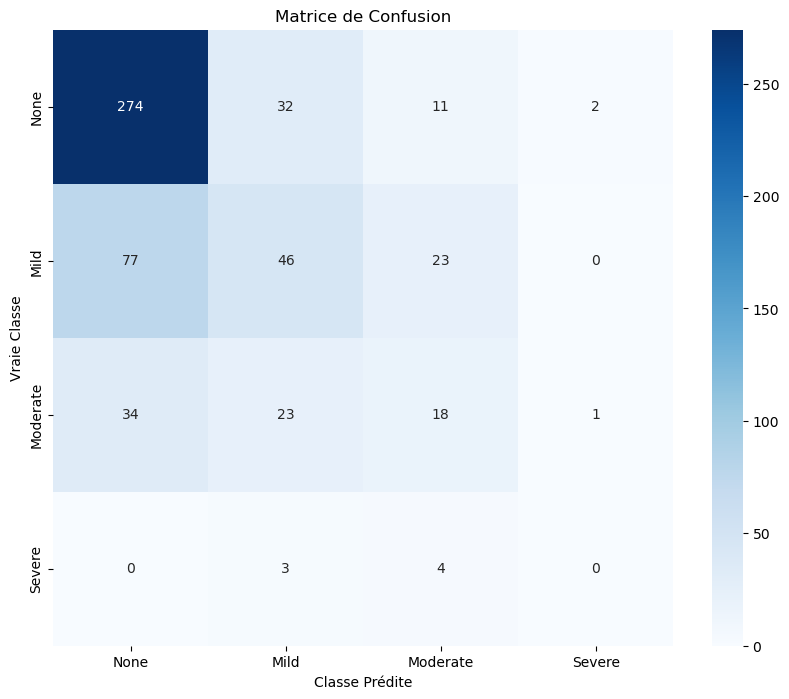

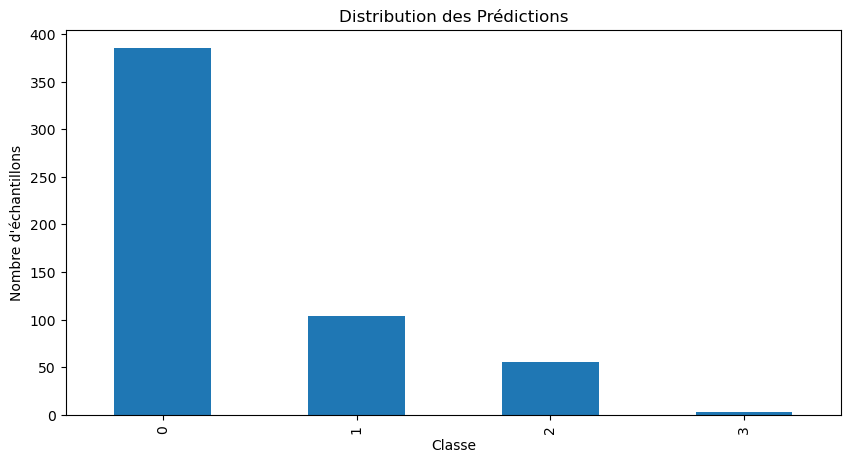


==================== Modèle mlp ====================
18/18 [==============================] - 0s 632us/step

=== Métriques Globales ===
Accuracy: 0.6186
Precision (macro): 0.3641
Recall (macro): 0.3527
F1-score (macro): 0.3496
Quadratic Weighted Kappa: 0.4158

=== Rapport de Classification Détaillé ===
              precision    recall  f1-score   support

        None       0.71      0.88      0.79       319
        Mild       0.44      0.25      0.32       146
    Moderate       0.30      0.28      0.29        76
      Severe       0.00      0.00      0.00         7

    accuracy                           0.62       548
   macro avg       0.36      0.35      0.35       548
weighted avg       0.57      0.62      0.58       548



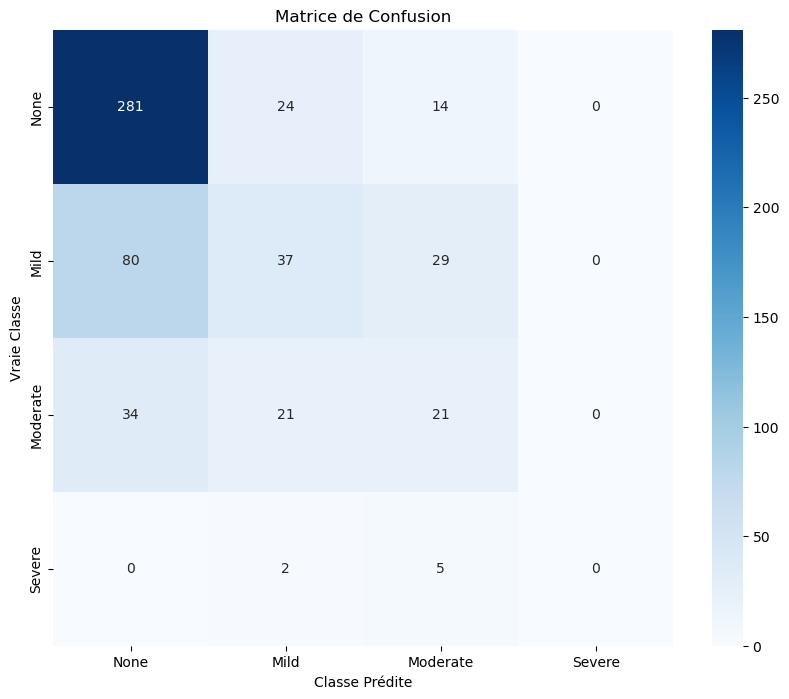

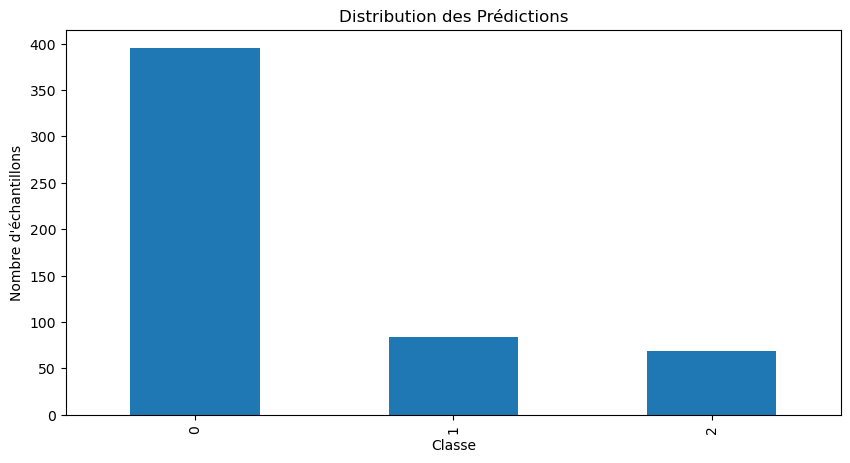


==================== Modèle cnn ====================
18/18 [==============================] - 0s 2ms/step

=== Métriques Globales ===
Accuracy: 0.6022
Precision (macro): 0.3393
Recall (macro): 0.3028
F1-score (macro): 0.2916
Quadratic Weighted Kappa: 0.2644

=== Rapport de Classification Détaillé ===
              precision    recall  f1-score   support

        None       0.65      0.93      0.76       319
        Mild       0.39      0.18      0.24       146
    Moderate       0.32      0.11      0.16        76
      Severe       0.00      0.00      0.00         7

    accuracy                           0.60       548
   macro avg       0.34      0.30      0.29       548
weighted avg       0.53      0.60      0.53       548



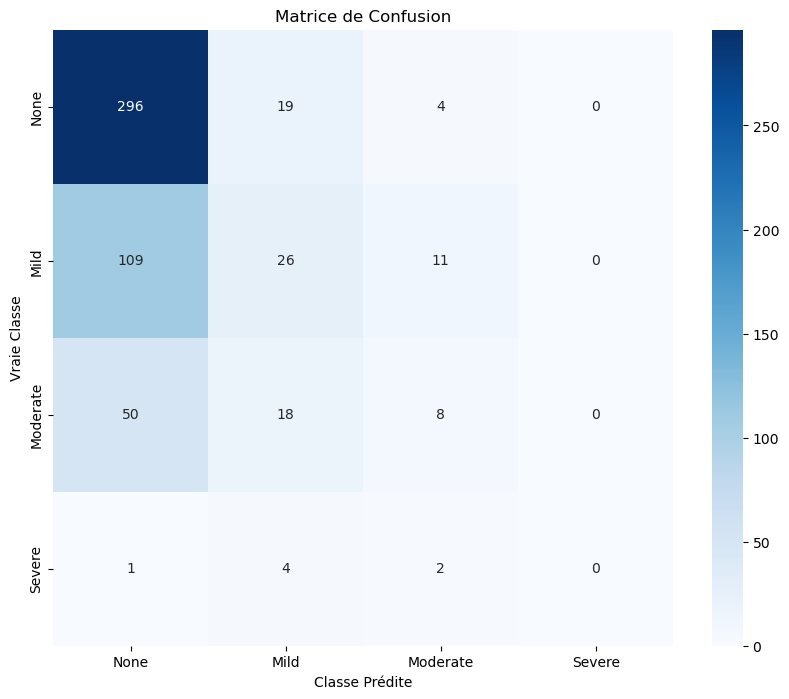

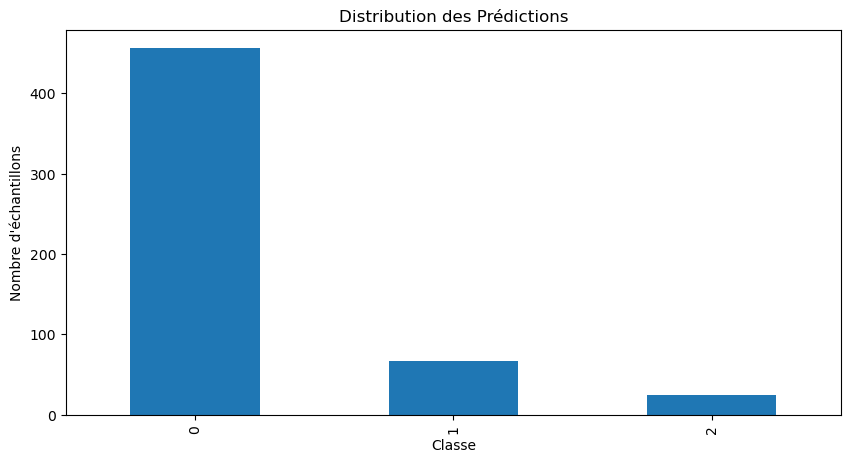


=== Comparaison des Métriques pour tous les Modèles ===
           linear     mlp     cnn
Accuracy   0.6168  0.6186  0.6022
Precision  0.3689  0.3641  0.3393
Recall     0.3527  0.3527  0.3028
F1-Score   0.3548  0.3496  0.2916
Kappa      0.3895  0.4158  0.2644


<Figure size 1200x600 with 0 Axes>

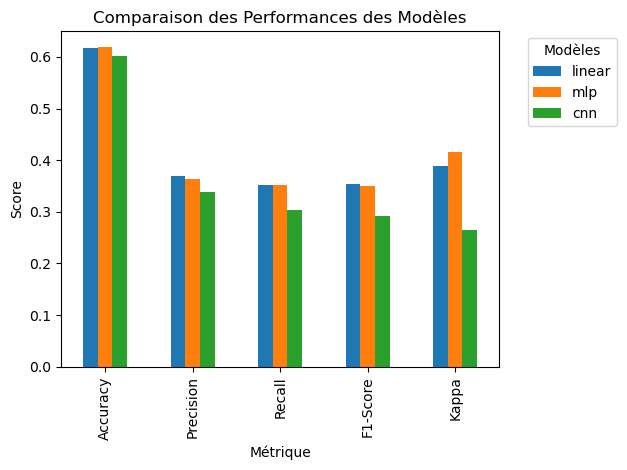

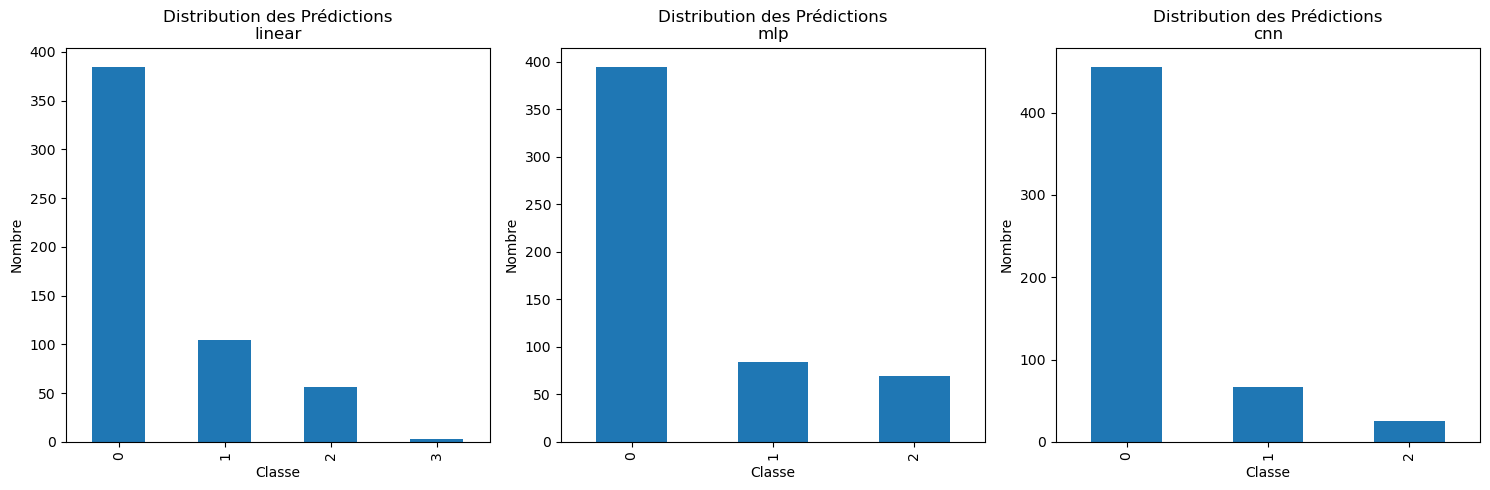

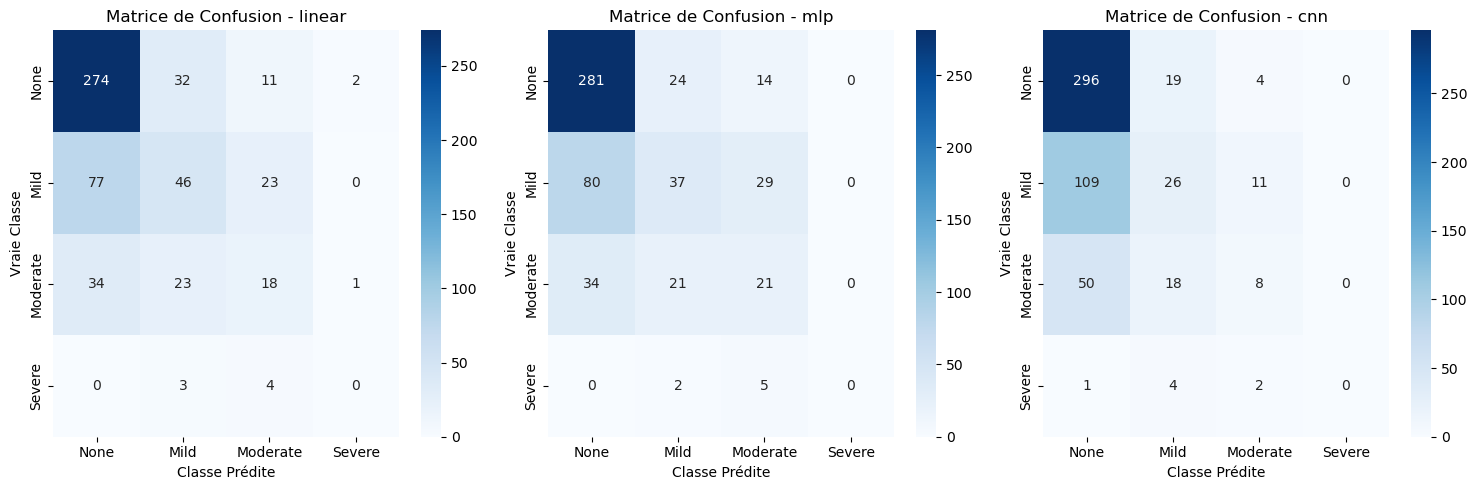

In [47]:
print("\n=== Évaluation Détaillée des Performances Modèles ===")
model_performances = {}

# Évaluation détaillée pour chaque modèle
for name, model in models.items():
    print(f"\n{'='*20} Modèle {name} {'='*20}")
    model_performances[name] = evaluate_model_performance(model, X_val, y_val)

# Création d'un DataFrame comparatif avec toutes les métriques
comparison_df = pd.DataFrame({
    name: {
        'Accuracy': perf['accuracy'],
        'Precision': perf['precision'],
        'Recall': perf['recall'],
        'F1-Score': perf['f1'],
        'Kappa': perf['kappa']
    }
    for name, perf in model_performances.items()
}).round(4)

# Affichage du tableau comparatif
print("\n=== Comparaison des Métriques pour tous les Modèles ===")
print(comparison_df)

# Visualisation comparative des métriques
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar')
plt.title('Comparaison des Performances des Modèles')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.legend(title='Modèles', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Distribution des prédictions par modèle
plt.figure(figsize=(15, 5))
for idx, (name, perf) in enumerate(model_performances.items(), 1):
    plt.subplot(1, len(models), idx)
    pred_dist = pd.Series(perf['predictions']).value_counts().sort_index()
    pred_dist.plot(kind='bar')
    plt.title(f'Distribution des Prédictions\n{name}')
    plt.xlabel('Classe')
    plt.ylabel('Nombre')
plt.tight_layout()
plt.show()

# Comparaison des matrices de confusion
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
for idx, (name, perf) in enumerate(model_performances.items()):
    sns.heatmap(perf['confusion_matrix'], 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=['None', 'Mild', 'Moderate', 'Severe'],
                yticklabels=['None', 'Mild', 'Moderate', 'Severe'],
                ax=axes[idx])
    axes[idx].set_title(f'Matrice de Confusion - {name}')
    axes[idx].set_ylabel('Vraie Classe')
    axes[idx].set_xlabel('Classe Prédite')
plt.tight_layout()
plt.show()